In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -avr /content/drive/'My Drive'/DetectingSarcasm .

'/content/drive/My Drive/DetectingSarcasm' -> './DetectingSarcasm'
'/content/drive/My Drive/DetectingSarcasm/Models' -> './DetectingSarcasm/Models'
'/content/drive/My Drive/DetectingSarcasm/Models/LSTM2DMaxPool.py' -> './DetectingSarcasm/Models/LSTM2DMaxPool.py'
'/content/drive/My Drive/DetectingSarcasm/Models/AttantionLSTM.py' -> './DetectingSarcasm/Models/AttantionLSTM.py'
'/content/drive/My Drive/DetectingSarcasm/Models/BidirectionalLSTM.py' -> './DetectingSarcasm/Models/BidirectionalLSTM.py'
'/content/drive/My Drive/DetectingSarcasm/Models/LSTM.py' -> './DetectingSarcasm/Models/LSTM.py'
'/content/drive/My Drive/DetectingSarcasm/Models/Weights' -> './DetectingSarcasm/Models/Weights'
'/content/drive/My Drive/DetectingSarcasm/Notebooks' -> './DetectingSarcasm/Notebooks'
'/content/drive/My Drive/DetectingSarcasm/Notebooks/LSTMs.ipynb' -> './DetectingSarcasm/Notebooks/LSTMs.ipynb'
'/content/drive/My Drive/DetectingSarcasm/Notebooks/BERT.ipynb' -> './DetectingSarcasm/Notebooks/BERT.ipynb

In [0]:
%cd DetectingSarcasm/Notebooks/Experements

/content/DetectingSarcasm/Notebooks/Experements


In [0]:
!ls

CleanedDataLSTMs.ipynb	TuneLSTMs.ipynb


In [0]:
import sys
sys.path.append('../../Models')
sys.path.append('../')

In [0]:
import torch
from torchtext import data

import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import spacy

import time
import copy
from torch.optim import lr_scheduler

from torchtext.vocab import Vectors, GloVe
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk

from utils import *

Let's look at our dataset:

In [0]:
df = pd.read_json("../../Data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [0]:
headlines = df['headline'].str.lower().str.replace("[^a-z]", " ")

In [0]:
headlines = headlines.apply(lambda headline: headline.split())

In [0]:
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

headlines = headlines.apply(lambda headline: [word for word in headline if word not in stop_words])

In [0]:
detokenized_headlines = [] 
for i in range(len(headlines)): 
    t = ' '.join(headlines[i]) 
    detokenized_headlines.append(t) 

df['headline'] = detokenized_headlines

Counting number of headlines with appropriate number of words:

In [0]:
count = df['headline'].str.split().apply(len).value_counts()
print(count)

7      4887
8      4606
6      4251
9      3507
5      3240
10     2181
4      2031
11     1186
3      1096
12      584
2       481
13      290
14      132
15       55
1        53
16       14
17       11
18        4
24        2
19        2
0         2
22        1
30        1
25        1
107       1
Name: headline, dtype: int64


We can see, that most part of headlines has less then 18 words. We will use this fact for choosing length of sequence.

Dropping unusefull column:

In [0]:
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [0]:
X = df['headline']
y = df['is_sarcastic']

In [0]:
!mkdir torchtext_data

Loading test and train sets to csv:

We will use 20% of dataset as test set.

In [0]:
split_and_save(text, target, test_size=0.2)

Preparing the data:

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
fix_length = 24
TEXT = data.Field(sequential=True, tokenize="spacy", fix_length=fix_length)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

In [0]:
train_data, test_data = data.TabularDataset.splits(
    path="torchtext_data/", train="train.csv", 
    test="test.csv",format="csv", skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)]
)

In [0]:
batch_size = 16

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), sort_key=lambda x: len(x.Text),
    batch_size=batch_size,
    device=device)

In [0]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 22895
Number of testing examples: 5724


Making vocabluary with GloVe with dimantion of 300:

In [0]:
TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:31, 2.20MB/s]                           
100%|█████████▉| 399807/400000 [00:34<00:00, 11679.14it/s]

In [0]:
word_embeddings = TEXT.vocab.vectors
output_size = 2 #two classes
num_layers = 1
hidden_size = 64 #num of units in our NN
embedding_length = 300 #dim of GloVe vector
vocab_size = len(TEXT.vocab)

Defining the model:


*   Simple LSTM - LSTMClassifier class 
*   LSTM with Attanrion - AttantionLSTMClassifier class 
*   Bidirectional LSTM - BidirectionalLSTMClassifier class
*   Bidirectional LSTM with 2D MaxPool layer - LSTM2DMaxPoolClassifier class





In [0]:
from LSTM import *

In [0]:
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, num_layers, word_embeddings)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.000551837, weight_decay=9.72328e-05)
criterion = nn.CrossEntropyLoss()

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
dataiter_dict = {'train': train_iterator, 'val': test_iterator}
dataset_sizes = {'train':len(train_data), 'val':len(test_data)}

Train model:

In [0]:
model_fit, res = train_model(model,
                             criterion,
                             optimizer,
                             scheduler = None,
                             dataiter_dict = dataiter_dict,
                             dataset_sizes = dataset_sizes,
                             batch_size = batch_size,
                             num_epochs=20)

starting
Epoch 1/20
----------
train total loss: 1.0063 
train sentiment_acc: 0.5862
val total loss: 0.9365 
val sentiment_acc: 0.6763
saving with loss of 0.9364891635796809 improved over previous 200

Epoch 2/20
----------
train total loss: 0.8610 
train sentiment_acc: 0.7247
val total loss: 0.8133 
val sentiment_acc: 0.7593
saving with loss of 0.8132821590145679 improved over previous 0.9364891635796809

Epoch 3/20
----------
train total loss: 0.8016 
train sentiment_acc: 0.7654
val total loss: 0.7862 
val sentiment_acc: 0.7748
saving with loss of 0.7862370917632145 improved over previous 0.8132821590145679

Epoch 4/20
----------
train total loss: 0.7760 
train sentiment_acc: 0.7849
val total loss: 0.7819 
val sentiment_acc: 0.7785
saving with loss of 0.7818529218497766 improved over previous 0.7862370917632145

Epoch 5/20
----------
train total loss: 0.7650 
train sentiment_acc: 0.7938
val total loss: 0.7736 
val sentiment_acc: 0.7839
saving with loss of 0.7736355444920138 improved 

As we can see, accuracy is much lower, so dataset is preprocessed enough.

Lets see at test and train accuracy plots:

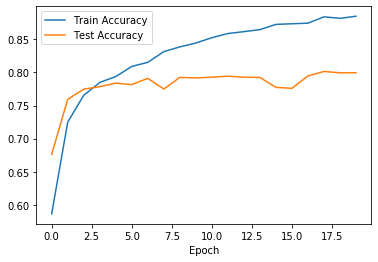

In [0]:
plt.plot(res['train_acc'], label = 'Train Accuracy')
plt.plot(res['val_acc'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()